# Run ephys element workflow

This notebook walks you through the steps to run the ephys workflow.  
The workflow requires neuropixels meta file and kilosort output data.  
A typical organization of the files is as follows:  

```
root_data_dir/
└───subject1/
│   └───session0/
│   │   └───imec0/
│   │   │   │   *imec0.ap.meta
│   │   │   └───ksdir/
│   │   │       │   spike_times.npy
│   │   │       │   templates.npy
│   │   │       │   ...
│   │   └───imec1/
│   │       │   *imec1.ap.meta   
│   │       └───ksdir/
│   │           │   spike_times.npy
│   │           │   templates.npy
│   │           │   ...
│   └───session1/
│   │   │   ...
└───subject2/
│   │   ...
```



Let's start by importing the relevant modules.

In [1]:
from scripts.conf_file_finding import try_find_conf_file
try_find_conf_file()

Local configuration file found !!, no need to run the configuration (unless configuration has changed)


In [2]:
import datetime
import pathlib
import numpy as np
import pylab as pl
from u19_pipeline import acquisition, ephys
from u19_pipeline.ephys import ephys_element, probe_element, get_session_directory
import datajoint as dj

Connecting alvaros@datajoint00.pni.princeton.edu:3306


In [9]:
dj.conn()

DataJoint connection (connected) alvaros@datajoint00.pni.princeton.edu:3306

In [3]:
key = {
    'subject_fullname': 'ms81_M005',
    'session_date': datetime.date(2021, 5, 5)}

The module ephys_element contains all the tables designed in the DataJoint ephys element, we could draw the diagram to see the schema structures

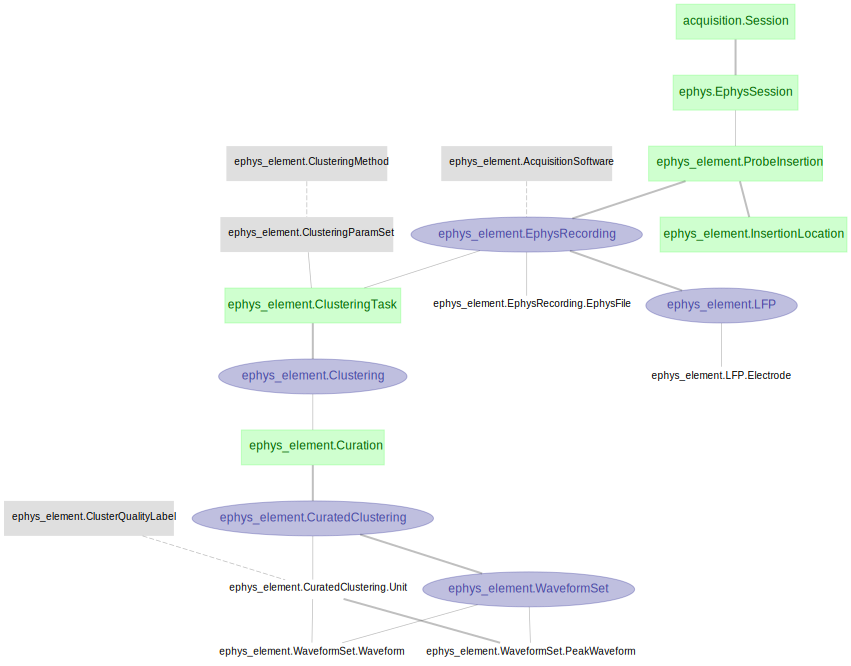

In [11]:
dj.Diagram(acquisition.Session) + ephys.EphysSession + dj.Diagram(ephys_element)

## Ingest Probe and ProbeInsertion by ephys_element_ingest

The original U19 pipeline contains a table `ephys.EphysSession` where datapath to the neuropixel meta file and the kilosort output folder were stored.

In [4]:
ephys.EphysSession() # Current sessions

subject_fullname username_mouse_nickname,session_date date of experiment,session_number number,ephys_directory Path were session file will be stored in bucket
hnieh_E105,2021-01-15,0,/Volumes/Tank/schottdorf/NPX/2021_01_15_E105/towersTask_g0
ms81_M004,2021-05-07,0,/Users/ms81/project_Neuropixel/analyses/data/210507_M004/
ms81_M005,2021-05-05,0,/M005/20210505
ms81_M005,2021-05-06,0,/M005/20210506


In [ ]:
# Do you have a new one to insert? This is how it is done:

key = {
    'subject_fullname': 'ms81_M005',
    'session_date': datetime.date(2021, 5, 5),
    'session_number': 0,
    'ephys_directory': '/Users/ms81/project_Neuropixel/analyses/data/210507_M004/'
}

ephys.EphysSession.insert1(key, skip_duplicates=True) # insert1 only works for one entry
ephys.EphysSession()

In [ ]:
dj.Diagram(ephys.EphysSession) + dj.Diagram(probe_element.Probe) + dj.Diagram(ephys_element.ProbeInsertion)

A module `ephys_element_ingest` was provided to process a ephys session based on the neuropixel meta file: ingest entries into tables `Probe` and `ProbeInsertion`

In [ ]:
from u19_pipeline.ingest import ephys_element_ingest

In [ ]:
for sess_key in ephys.EphysSession.fetch('KEY'):
    ephys_element_ingest.process_session(sess_key)

In [ ]:
probe_element.Probe()

In [ ]:
ephys_element.ProbeInsertion()

## Populate EphysRecording

By populating `ephys_element.EphysRecording`, three tables will be ingested:
+ `probe_element.EelectrodeConfig` table contains the configuration information of the electrodes used, i.e. which 384 electrodes out of the total 960 on the probe were used in this ephys session
+ `ephys_element.EphysRecording` table specifies which ElectrodeConfig is used in a particular ephys session
+ `ephys_element.EphysRecording.EphysFile` table saves the file path of SpikeGLX meta file.

In [ ]:
dj.Diagram(ephys_element.ProbeInsertion) + probe_element.ElectrodeConfig\
+ ephys_element.EphysRecording + ephys_element.EphysRecording.EphysFile

In [ ]:
ephys_element.EphysRecording()

In [ ]:
ephys_element.EphysRecording.populate(display_progress=True)

Here is an overview of the Electrode used in a EphysRecording for a particular probe insertion

In [ ]:
probe_insertion_key = ephys_element.ProbeInsertion.fetch('KEY', limit=1)[0]
ephys_element.EphysRecording * probe_element.ElectrodeConfig.Electrode & probe_insertion_key

In [ ]:
ephys_element.EphysRecording.EphysFile()

Note that the filepath is a relative path to the `ephys_root_data_dir` in `dj.config['custom']`

## Populate clustering results

The next major table in the ephys pipeline is the `ClusteringTask`, which is a manual table that is inserted when a Kilosort2 clustering task is finished and the clustering results are ready for processing. The `ClusteringTask` table depends on the table `ClusteringParamSet`, which are the parameters of the clustering task and needed to be inserted first. A method of the class `ClusteringParamSet` called `insert_new_params` helps on the insertion of params_set

In [ ]:
dj.Diagram(ephys_element.EphysRecording) + ephys_element.ClusteringParamSet + ephys_element.ClusteringTask

In [ ]:
# insert clustering task manually
params_ks = {
    "fs": 30000,
    "fshigh": 150,
    "minfr_goodchannels": 0.1,
    "Th": [10, 4],
    "lam": 10,
    "AUCsplit": 0.9,
    "minFR": 0.02,
    "momentum": [20, 400],
    "sigmaMask": 30,
    "ThPr": 8,
    "spkTh": -6,
    "reorder": 1,
    "nskip": 25,
    "GPU": 1,
    "Nfilt": 1024,
    "nfilt_factor": 4,
    "ntbuff": 64,
    "whiteningRange": 32,
    "nSkipCov": 25,
    "scaleproc": 200,
    "nPCs": 3,
    "useRAM": 0
}
ephys_element.ClusteringParamSet.insert_new_params(
    'kilosort2', 0, 'Spike sorting using Kilosort2', params_ks)
ephys_element.ClusteringParamSet()

We are then able to insert an entry into the `ClusteringTask` table. One important field of the table is `clustering_output_dir`, which specifies the Kilosort2 output directory for the later processing. For the current pipeline, the directory could be reconstructed from directories stored in existing tables

In [ ]:
dj.Diagram(ephys_element.EphysRecording) + ephys_element.ClusteringTask + ephys_element.Clustering

In [ ]:
ephys_element.ClusteringTask.describe();

In [ ]:
# Specify path and animal information

ephys_key = dict(
    subject_fullname='ms81_M004', session_date='2021-05-07', session_number=0, insertion_number=0)
ephys_dir = '210507_M004/towersTask_g0_imec0/'

In [ ]:
ephys_element.ClusteringTask.insert1(
    dict(**ephys_key, paramset_idx=0, clustering_output_dir=ephys_dir), skip_duplicates=True)
ephys_element.ClusteringTask()

We are then able to populate the clustering results. The `Clustering` table now validates the Kilosort2 outcomes. In the future release of elements-ephys, this table will be used to trigger Kilosort2.

In [ ]:
ephys_element.Clustering.populate(display_progress=True)

# Curation and CuratedClustering

The next step in the pipeline is the curation of spike sorting results. If a manual curation was implemented, an entry needs to be manually inserted into the table `Curation`, which specifies the directory to the curated results in `curation_output_dir`. If we would like to process the Kilosort2 outcome directly, an entry is also needed in `Curation`. A method `create1_from_clustering_task` was provided to help this insertion. It copies the `clustering_output_dir` in `ClusteringTask` to the field `curation_output_dir` in the table `Curation` with a new `curation_id`.

In [ ]:
dj.Diagram(ephys_element.Clustering) + ephys_element.Curation + ephys_element.CuratedClustering \
+ ephys_element.CuratedClustering.Unit

In [ ]:
key = (ephys_element.ClusteringTask & ephys_key).fetch1('KEY')
ephys_element.Curation().create1_from_clustering_task(key)

In [ ]:
ephys_element.Curation()

Then we could populate table `CuratedClustering`, ingesting either the output of Kilosort2 or the curated results.

In [ ]:
ephys_element.CuratedClustering.populate(display_progress=True)

The part table `CuratedClustering.Unit` contains the spike sorted units

In [ ]:
ephys_element.CuratedClustering.Unit()

## Populate LFP and waveform

In [ ]:
ephys_element.LFP.populate(display_progress=True)

In [ ]:
ephys_element.LFP()

The current workflow also contain tables to save spike waveforms:

`WaveformSet`: a table to drive the processing of all spikes waveforms resulting from a CuratedClustering.  
`WaveformSet.Waveform`: mean waveform across spikes for a given unit and electrode.  
`WaveformSet.PeakWaveform`: mean waveform across spikes for a given unit at the electrode with peak spike amplitude.

In [ ]:
# May take a while to populate depending on data size.
ephys_element.WaveformSet.populate(display_progress=True)

# Synchronize ePhys and Behavior

Populate the tables, using the nidaq file produced by spikeGLX. This is done automatically and produces a record of VR iteration numbers measured in the time of the ePhys setup.

In [ ]:
ephys.BehaviorSync()

In [ ]:
dj.config

In [ ]:
get_session_directory(key)

In [ ]:
ephys.BehaviorSync.populate(key)

In [ ]:
ephys.BehaviorSync()

Once the synchronization files have been produces, the all Clusters/spikes can be binned into iterations.

In [7]:
ephys.CuratedClustersIteration.populate(key)

\\bucket.pni.princeton.edu\Bezos-center\Manuel\neuropixel\manuel
<class 'str'>
/M005/20210505
<class 'str'>
\\bucket.pni.princeton.edu\Bezos-center\Manuel\neuropixel\manuel/M005/20210505
<class 'str'>
\\bucket.pni.princeton.edu\Bezos-center\Manuel\neuropixel\manuel\M005\20210505\towers_task_g0
\\bucket.pni.princeton.edu\Bezos-center\Manuel\neuropixel\manuel
<class 'str'>
/M005/20210505
<class 'str'>
\\bucket.pni.princeton.edu\Bezos-center\Manuel\neuropixel\manuel/M005/20210505
<class 'str'>
\\bucket.pni.princeton.edu\Bezos-center\Manuel\neuropixel\manuel\M005\20210505\towers_task_g0


This allows to plot neuronal responses responses. Here is an example

In [10]:
ephys.CuratedClustersIteration.Unit & key & 'unit = 7'

subject_fullname username_mouse_nickname,session_date date of experiment,session_number number,insertion_number,paramset_idx,curation_id,unit,spike_counts_iteration number of spikes during each iteration. have length as the number of iterations - 1,firing_rate_before_first_iteration,firing_rate_after_last_iteration
ms81_M005,2021-05-05,0,0,0,1,7,=BLOB=,0.321505,3.72292
ms81_M005,2021-05-05,0,1,0,1,7,=BLOB=,6.21089,2.39695


In [ ]:
key = {"subject_fullname": "ms81_M004", "insertion_number": 0, "session_date": '2021-05-07', 'curation_id': 1}

ephys.BehaviorSync() & key

In [11]:
spikes = (ephys.CuratedClustersIteration.Unit & key & 'insertion_number = 0' & 'unit = 7').fetch1('spike_counts_iteration')

behavior = dj.create_virtual_module('subject', 'u19_behavior')
pos, time = (behavior.TowersBlock().Trial() & key).fetch('position', 'trial_time')

position_at_each_iteration = []
for trial in range(len(pos)):
    pp = pos[trial][:,1]
    snip = np.zeros(len(time[trial]))*np.NaN
    snip[0:len(pp)] = pp
    position_at_each_iteration = np.append(position_at_each_iteration, snip)

ValueError: x and y must have same first dimension, but have shapes (470786,) and (470789,)

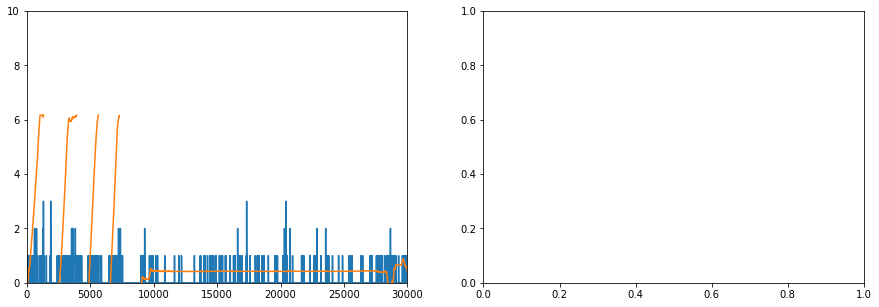

In [15]:
pl.figure(figsize=(15,5))
pl.subplot(1,2,1)
pl.plot(spikes)
pl.plot(position_at_each_iteration/50)
pl.ylim([0,10])
pl.xlim([0,30000])

pl.subplot(1,2,2)
pl.plot(position_at_each_iteration[1:], spikes, '.')

TODO: 
    - Sync table under ephys module.
    - Unit table could contain the clustering results for multiple sorters. U19 team needs to implemnt the workflow for other sorters by overwriting the make function of the table `ephys_element.Clustering`. e.g.
    ```
    def ironclust_make(key):
    if (ephys_element.ClusteringMethod & key).fetch1('clustering_method') != 'ironclust':
        return
    pass
    ephys_element.CuratedClustering.make = ironclust_make
    ephys_element.CuratedClustering.populate()
    ```